In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set some Seaborn options
sns.set_context('notebook')

from IPython.core.display import HTML
def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

# Optimization

Optimization is the process of finding the *minima* or *maxima* of a function. Consider a function:

$$f: \mathbf{R} \rightarrow \mathbf{R}$$

where $f',f''$ are continuous. A point $x^*$ is a *global* maximum if:

$$f(x) \le f(x^*) \, \forall \, x$$

or a *local* maximum if:

$$f(x) \le f(x^*)$$ 
$$\forall \, x:|x-x^*| \lt \epsilon$$

Necessary conditions:

1. $f'(x^*) = 0$
2. $f''(x^*) \le 0$ (sufficient if $f''(x^*) \lt 0$)

We will consider **local search** methods that generate a series of values that converge to the maximum:

$$x_0, x_1, x_2, \ldots \rightarrow \text{argmax}(f)$$

## Example: Maximum Likelihood

**Maximum likelihood** (ML) is an approach for estimating the parameters of statistical models. The resulting estimates from ML have good theoretical properties, so it is a widely-used method. 

There is a ton of theory regarding ML. We will restrict ourselves to the mechanics here.

Say we have some data $y = y_1,y_2,\ldots,y_n$ that is distributed according to some distribution:

<div style="font-size: 120%;">  
$$Pr(Y_i=y_i | \theta)$$
</div>

Here, for example, is a **Poisson distribution** that describes the distribution of some discrete variables, typically *counts*: 

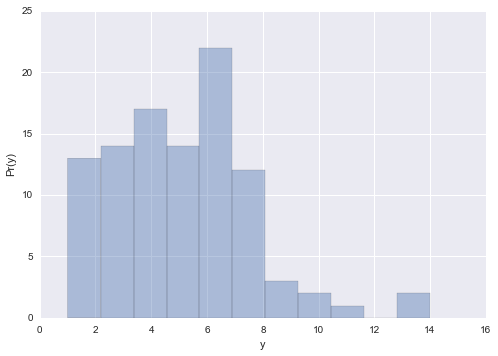

In [2]:
y = np.random.poisson(5, size=100)
sns.distplot(y, kde=False)
plt.xlabel('y'); plt.ylabel('Pr(y)');

The product $\prod_{i=1}^n Pr(y_i | \theta)$ gives us a measure of how **likely** it is for the parameters $\theta$ to have generated values $y_1,\ldots,y_n$. Maximum likelihood fitting consists of choosing the appropriate function $l= Pr(Y|\theta)$ to maximize for a given set of observations. We call this function the *likelihood function*, because it is a measure of how likely the parameter values are if the model is true.

> Given these data, how likely is this model?

In the above model, the data were drawn from a Poisson distribution with parameter $\lambda =5$.

$$L(y|\lambda=5) = \frac{e^{-5} 5^y}{y!}$$

So, for any given value of $y$, we can calculate its likelihood:

In [3]:
poisson_like = lambda x, lam: np.exp(-lam) * (lam**x) / (
                                     np.arange(x)+1).prod()

lam = 6
value = 10
poisson_like(value, lam)

0.041303093412337726

Or, for numerical stability, the log-likelihood:

In [4]:
poisson_loglike = lambda x, lam: -lam + np.log(lam**x) - np.log((np.arange(x)+1).prod())

poisson_loglike(value, lam)

-3.1868178807949672

In [5]:
np.sum(poisson_loglike(yi, lam) for yi in y)

-232.07732315366195

In [6]:
lam = 8
np.sum(poisson_loglike(yi, lam) for yi in y)

-285.93483034815728

We can plot the likelihood function for any value of the parameter(s):

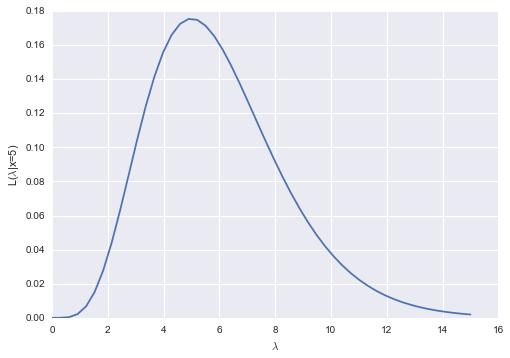

In [7]:
lambdas = np.linspace(0,15)
x = 5
plt.plot(lambdas, [poisson_like(x, l) for l in lambdas])
plt.xlabel('$\lambda$')
plt.ylabel('L($\lambda$|x={0})'.format(x))

How is the likelihood function different than the probability distribution (or mass) function? The likelihood is a function of the parameter(s) *given the data*, whereas the PDF (PMF) returns the probability of data given a particular parameter value. Here is the PMF of the Poisson for $\lambda=5$.

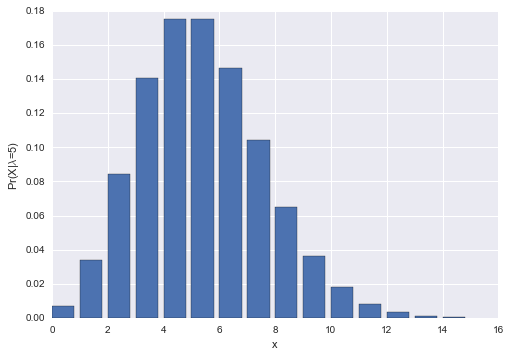

In [8]:
lam = 5
xvals = np.arange(15)
plt.bar(xvals, [poisson_like(x, lam) for x in xvals])
plt.xlabel('x')
plt.ylabel('Pr(X|$\lambda$=5)')

Why are we interested in the likelihood function? 

A reasonable estimate of the true, unknown value for the parameter is one which **maximizes the likelihood function**. So, inference is reduced to an optimization problem.

### Example: Nashville rainfall data

Consider again the Nashville precipitation data (`nashville_precip.txt`), in your data directory, which records the monthly rainfall from 1871 to 2011. Since this is continuous, positive data, it may be possible to model it using a Gamma distribution. If so, we need to maximize:

$$\begin{align}l(\alpha,\beta) &= \sum_{i=1}^n \log[\beta^{\alpha} x^{\alpha-1} e^{-x/\beta}\Gamma(\alpha)^{-1}] \cr 
&= n[(\alpha-1)\overline{\log(x)} - \bar{x}\beta + \alpha\log(\beta) - \log\Gamma(\alpha)]\end{align}$$

where $n = 2012 − 1871 = 141$ and the bar indicates an average over all *i*. We choose $\alpha$ and $\beta$ to maximize $l(\alpha,\beta)$.

Notice $l$ is infinite if any $x$ is zero. We do not have any zeros, but we do have an NA value for one of the October data.

### Finding the MLE

To find the maximum of any function, we typically take the *derivative* with respect to the variable to be maximized, set it to zero and solve for that variable. 

$$\frac{\partial l(\alpha,\beta)}{\partial \beta} = n\left(\frac{\alpha}{\beta} - \bar{x}\right) = 0$$

$$\frac{\partial l(\alpha,\beta)}{\partial \alpha} = n\left(\log(\beta) -\frac{\Gamma(\alpha)'}{\Gamma(\alpha)} + \overline{\log(x)}\right) = 0$$

So, in general we are finding:

$$l(\theta) = \left(\frac{d\theta}{d\theta_1}, \cdots, \frac{d\theta}{d\theta_n}\right) = \mathbf{0}$$

Thus, we seek the root of the score equation.

In Python, we can use Sympy to obtain the first derivative of the gamma likelihood with respect to $\beta$:

In [9]:
# via Sympy
from sympy import *

a, b, x = symbols('a b x')
gamma_dist = (a-1)*log(x) - x*b + a*log(b) - log(gamma(a))
diff(gamma_dist, b)

a/b - x

Which can be solved as $\beta = \alpha/\bar{x}$. However, plugging this into the derivative with respect to $\alpha$ yields:

$$\frac{\partial l(\alpha,\beta)}{\partial \alpha} = \log(\alpha) + \overline{\log(x)} - \log(\bar{x}) - \frac{\Gamma(\alpha)'}{\Gamma(\alpha)} = 0$$

This has no closed form solution. We must use ***numerical optimization***!

## Bisection method

The bisection method performs numerical root-finding for univariate problems. It works on continuous functions on $[a_0, b_0]$ where:

$$f^{\prime}(a_0)f^{\prime}(b_0) \le 0$$

which implies that there is a local maximum (minimum) between the two values somewhere.

The initial interval $[a_0, b_0]$ is arbitrary, as long as the above condition is met.

The algorithm iteratively shrinks the interval $[a_i,b_i]$, by subdividing it and retaining the subinterval for which the above condition is still true. If there are multiple optima, bisection will only find one of them.

Due to a number of factors, including rounding error in floating point calculations, iterative procedures can easily run indefinitely. To avoid this, we specify a **stopping rule** that halts the algorithm based on some pre-defined convergence criteria.

Since we are searching for a root, one approach is to monitor the convergence of $f^{\prime}((a_i + b_i)/2)$ to zero. However, when the likelihood is very flat, there can be very large changes in the estimated value even when $f^{\prime}(x)$ is small. Instead, we should monitor the difference in values from one iteration to the next.

> **absolute convergence criterion**:
> 
> $$| x_{i+1} - x_{i} | \lt \epsilon$$
> 
> where $\epsilon$ is a chosen tolerance.
> 
> **relative convergence criterion**:
> 
> $$\frac{| x_{i+1} - x_{i} |}{|x_{i}|} \lt \epsilon$$
> 
> In general:
> 
> * if values of $x$ are orders of magnitude larger (smaller) than $\epsilon$, absolute convergence may stop too late (soon)
> * if the solution is too close to zero, relative convergence may become unstable


Note that for the bisection method:

$$b_t - a_t = \frac{b_0 - a_0}{2^t}$$

which means that for a given $\epsilon$, we require: 

$$t > \log_2\left(\frac{b_0 - a_0}{\epsilon}\right)$$

Reducing $\epsilon$ by a factor of 10 means increasing $t$ by $\log_2(10) \approx 3.3$.

It is also wise to place an absolute limit on the number of iterations, in case the algorithm diverges or cycles.

In [10]:
class ConvergenceError(Exception): pass

def bisection(func, a, b, tol=1e-9, max_iter=100):

    # Check initial values
    if a >= b:
        raise ValueError('Right value must be larger than left')
    
    fa, fb = func([a, b])
    
    if fa*fb > 0:
        raise ValueError('No maximum between specified values')
    
    i = 0
    while (b - a) > tol:
        
        # More stable than c = (b + a)/2.
        c = a + (b - a)/2.
        fc = func(c)
        
        if fa*fc < 0:
            b,fb = c,fc
        else:
            a,fa = c,fc
            
        i +=1
        
        if i == max_iter:
            raise ConvergenceError('The algorithm did not converge in {0} iterations'.format(max_iter))
        
    return((a+b)/2., i)

To apply this algorithm to the precipitation data, we need a function for the derivative of the log likelihood with respect to one of the parameters, in this case, beta:

In [11]:
precip = pd.read_table("../data/nashville_precip.txt", sep='\s+')

# Calculate statistics
log_mean = precip.mean().apply(np.log)
mean_log = precip.apply(np.log).mean()

In [12]:
from scipy.special import psi

def dlgamma(m, month = 'Dec'): 
    return np.log(m) - psi(m) - log_mean[month] + mean_log[month]

where `log_mean` and `mean_log` are $\log{\bar{x}}$ and $\overline{\log(x)}$, respectively; `psi` is the logarithm of the gamma function.

To obtain reasonable starting points, there are a handful of strategies:

* plotting the function, and obtain a visual estimate
* preliminary estimates via other approximate solutions
* trial and error

Here, we will plot the function:

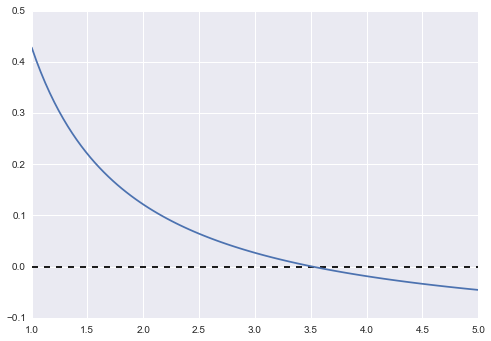

In [13]:
x = np.linspace(1, 5, 100)
y = dlgamma(x)
plt.plot(x,y)
plt.hlines(0, 1, 5, linestyles='--')

In [14]:
bisection(dlgamma, 2, 4, tol=1e-7)

(3.5189678966999054, 25)

## Convergence Order

We can quantify the *efficiency* of root-finding algorithms by calculating its **order of convergence**.

If an algorithm satisfies $\lim_{i \rightarrow \infty} \epsilon_i = 0$, then the parameter $\beta$ is the order of convergence according to:

$$\lim_{i \rightarrow \infty} \frac{|\epsilon_{i+1}|}{|\epsilon_{i}|^{\beta}} = c$$

for some constant $c$. Larger values of $\beta$ are the result of faster convergence.

Note that there is usually a tradeoff of speed vs. robustness.

The bisection method is unusual in that it does not meet the criterion for order of convergence, with the ratio above being possibly unbounded. In practice, it tends to exhibit approximately linear convergence.

## Fixed Point Iteration

Another method for finding roots computationally is *fixed-point iteration*. A **fixed point** of a function is a point at which the evaluation of the point equals the point itself. Mathematically, for some function $g:\mathbf{R} \Rightarrow \mathbf{R}$, a fixed point is:

$$a \in \mathbf{R}: g(a) = a$$

So, if we define our function $f$ as:

$$f(x) = c(g(x)-x)$$

then we can find the root of $f$ when we find the fixed point of $g$. Conversely:

$$g(x) = cf(x) + x$$

The method begins with an initial guess $x_0$, from which we generate $x_1 = g(x_0)$, then $x_2 = g(x_1)$, etc.

In general, this is a 1st-order recurrence equation:

$$x_{n+1} = g(x_{n})$$

We can show that $x_n \rightarrow a$ is a fixed point of $g$.

$$a = \lim_{n \rightarrow \infty} x_{n+1} = \lim_{n \rightarrow \infty} g(x_n)$$
$$ = g(\lim_{n \rightarrow \infty} x_n) = a$$

therefore, $a$ is a fixed point of $g$.

Unfortunately, this convergence does not always take place. For example, consider the following functions:

$$g_1(x) = x^{1.5}, \, g_2(x) = x^{0.75}$$

both $g_1, g_2$ have fixed points at 1 (by inspection), but $g_1$ diverges.

In general,

* the algorithm converges if $|g'(a)<1|$, and diverges otherwise.
* the initial value should be in the "neighborhood" of $x_0$ to guarantee convergence.

In practice, we may *converge* to $a$ without reaching it. We want to stop when $x_n$ is "close enough":

$$ |x_n - x_{n-1}| \le \epsilon$$

### Exercise: Gamma MLE

Implement a fixed point algorithm, and use it to calculate the gamma MLE for one of the months of precipitation in Nashville.

In [15]:
# Type your answer here

## Newton's Method

Bracketing methods like bisection, which bounds a root within a sequence of intervals that gradually decrease in length, are slow relative to other approaches. A much faster root-finding method is **Newton's method**. 

If we have a function $f$ that is twice-differentiable, we can approximate the root of its derivative using a Taylor series expansion:

$$f^{\prime}(x^*) \approx f^{\prime}(x_i) + (x^* - x_i)f^{\prime\prime}(x_i) = 0$$

We can approximate $f^{\prime}$ by its tangent at $x_i$, and then approximate the root of $f^{\prime}$ by the root of the tangent line:

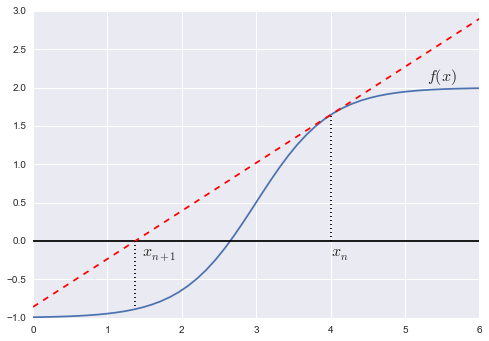

In [16]:
# some function
func = lambda x: 3./(1 + 400*np.exp(-2*x)) - 1
xvals = np.linspace(0, 6)
plt.plot(xvals, func(xvals))
plt.text(5.3, 2.1, '$f(x)$', fontsize=16)
# zero line
plt.plot([0,6], [0,0], 'k-')
# value at step n
plt.plot([4,4], [0,func(4)], 'k:')
plt.text(4, -.2, '$x_n$', fontsize=16)
# tangent line
tanline = lambda x: -0.858 + 0.626*x
plt.plot(xvals, tanline(xvals), 'r--')
# point at step n+1
xprime = 0.858/0.626
plt.plot([xprime, xprime], [tanline(xprime), func(xprime)], 'k:')
plt.text(xprime+.1, -.2, '$x_{n+1}$', fontsize=16)

If we solve for $x^*$, this gives:

$$x^* = x_i - \frac{f'(x_i)}{f''(x_i)}$$

This result is just another approximation, however, so this formula is iterated as:

$$x_{i+1} = x_i - \frac{f'(x_i)}{f''(x_i)}$$

In the specific case of a MLE problem, this becomes:

$$\theta_{i+1} = \theta_i - \frac{l'(\theta_i)}{l''(\theta_i)}$$

### Convergence

Using Newton's algorithm, $x_i \rightarrow x^*$ quickly, provided:

1. $f'(x^*)=0$
2. $f''(x^*)<0$
3. $f''$ is *Lipschitz-continuous* in the neighborbood of $x^*$

> Lipschitz continuous if there exists a $k$ such that:
>
> $|f''(x) - f''(y)| \le k|x-y| \, \forall \, x,y$

The following implements Newton's method in Python:

In [17]:
def newt(f, f_prime, x0, tol=1e-9, max_iter=100, **kwargs):
    """
    Newton-Raphson algorithm for solving f(x) == 0
    
    f: a function of a single variable, x
    f_prime: a function that returns the derivative of f at x
    x0: the initial guess at the fixed point
    tol: minimum distance of consecutive guesses before algorithm stops
    max_iter: maximum number of iterations to converge to tolerance before
        algorithm stops
    """
    
    # Initialize
    x = x0
    fx, fpx = f(x, **kwargs), f_prime(x, **kwargs)
    i = 0
    
    # Loop until conditions met
    while (abs(fx) > tol) and (i < max_iter):
        
        x -= fx/fpx
        fx, fpx = f(x), f_prime(x)
        i += 1
                
    if abs(fx) > tol:
        raise ConvergenceError('Algorithm failed to converge')

    return x

To apply the Newton-Raphson algorithm, we need a function that returns a vector containing the **first and second derivatives** of the function with respect to the variable of interest. We defined the first derivative above; the second derivative is as follows:

In [18]:
from scipy.special import polygamma

dl2gamma = lambda m, **kwargs: 1./m - polygamma(1, m)

`polygamma` is a complex function of the gamma function that result when you take the second derivative of that function.

In [19]:
# Alpha MLE for December
alpha_mle = newt(dlgamma, dl2gamma, 2, month = 'Dec')
alpha_mle

3.5189679152158253

And now plug this back into the solution for beta:

<div style="font-size: 120%;">  
$$ \beta  = \frac{\alpha}{\bar{X}} $$
</div>

In [20]:
beta_mle = alpha_mle/precip.mean()[-1]
beta_mle

0.84261607547835782

Newton's method is also available to us via SciPy:

In [21]:
from scipy.optimize import newton

For some common distributions, SciPy includes methods for fitting via MLE:

In [22]:
from scipy.stats import gamma

gamma.fit(precip.Dec)

(2.2427517753152308, 0.65494604470188622, 1.570073932063466)

This fit is not directly comparable to our estimates, however, because SciPy's `gamma.fit` method fits an odd 3-parameter version of the gamma distribution. If we set the location parameter to zero:

In [23]:
scipy_params = gamma.fit(precip.Dec, floc=0.)
scipy_params

(3.5189679152399753, 0.0, 1.1867801114824814)

To complicate things further, SciPy's gamma distribution uses a parameterization that employs the inverse of beta for its scale parameter.

In [24]:
1./scipy_params[-1]

0.84261607548414119

### Example

This animation illustrates how Newton's method estimates the minimum of a simple polynomial function, $2x^4 + 3x^3 + 3$.

It requires the installation of Jake van der Plas' `JSAnimation` package:

In [25]:
try:
    from JSAnimation.IPython_display import display_animation
except ImportError:
    !pip install git+https://github.com/jakevdp/JSAnimation.git


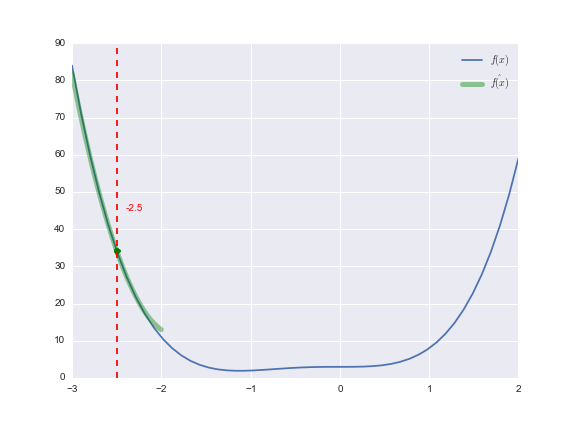
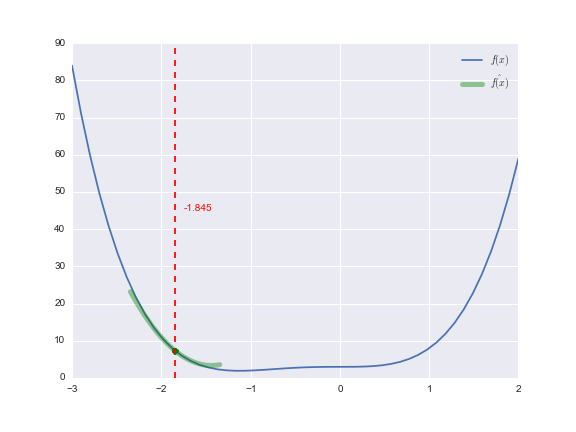
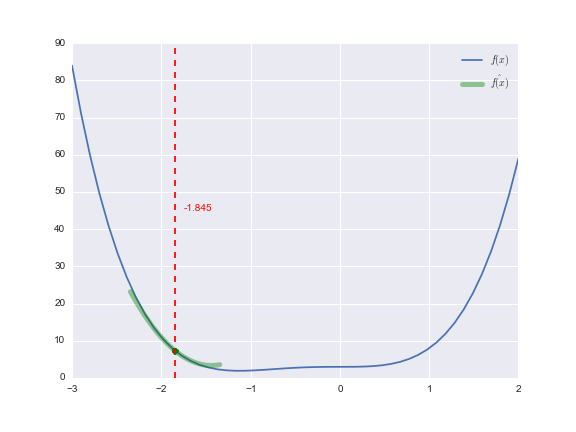
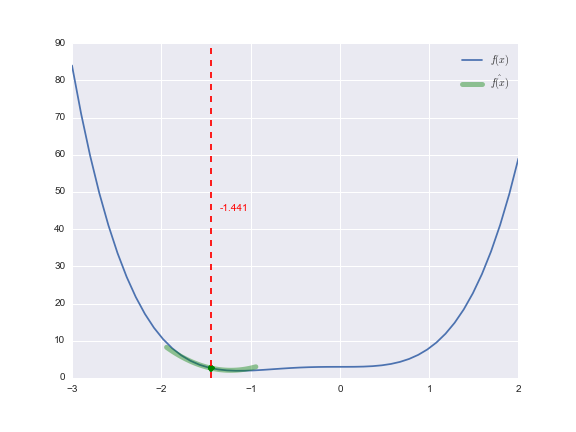
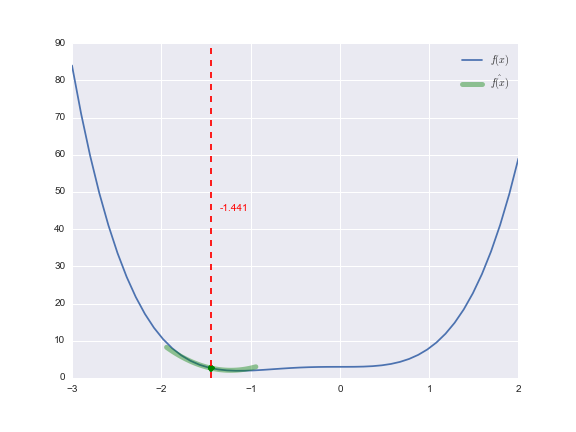
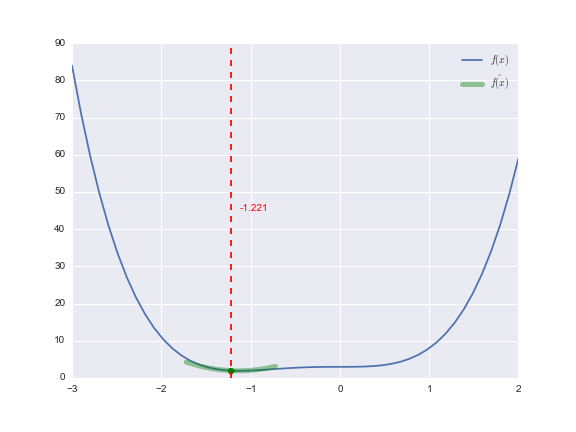
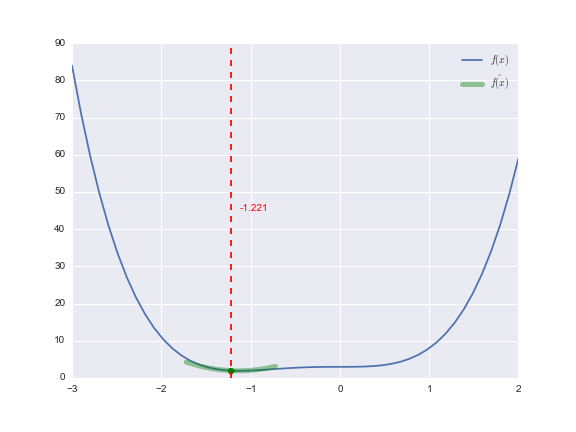
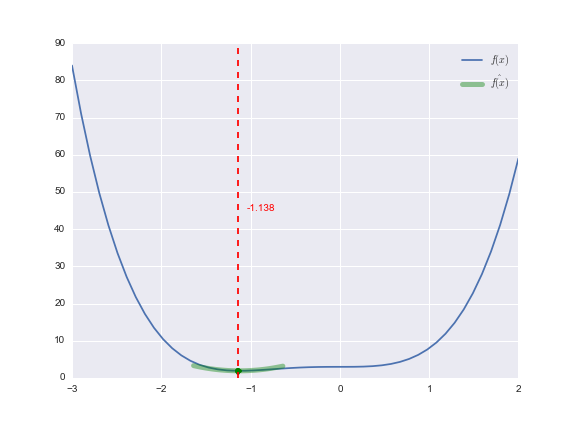
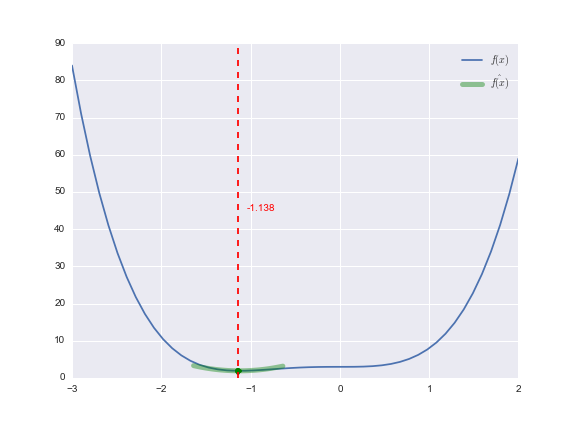
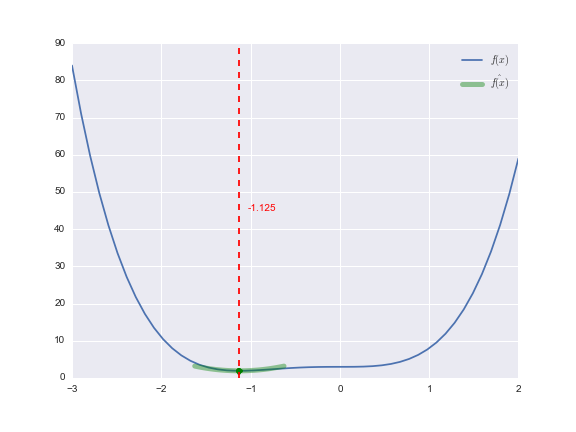
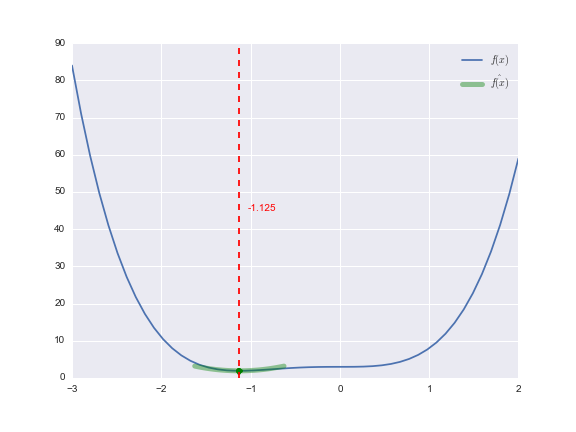
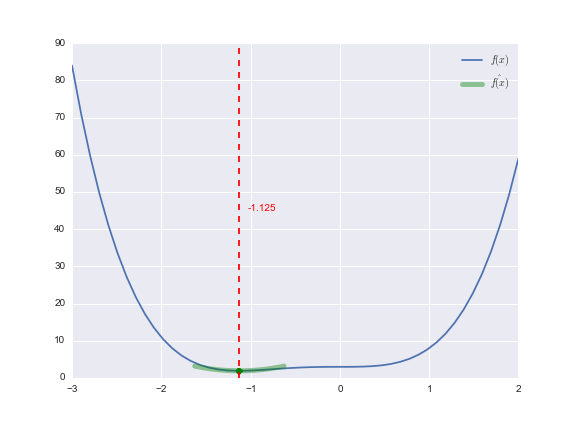
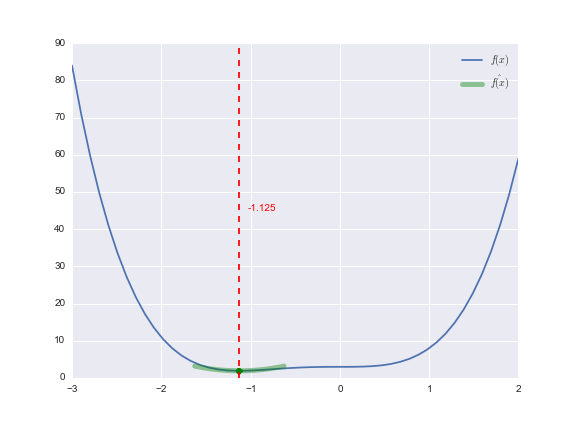
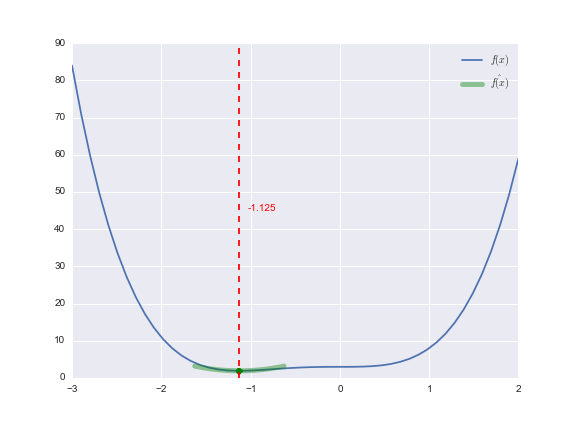
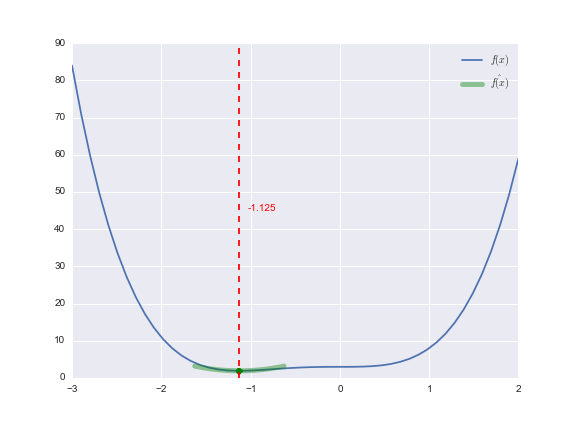

In [28]:
from matplotlib import animation

f = lambda x: 2 * x**4 + 3 * x**3 + 3 

df = lambda x: 8 * x**3 + 9 * x**2

ddf = lambda x: 24 * x**2 + 18*x

taylorf = lambda x, dx: f(x) + df(x) * dx + 0.5 * ddf(x) * dx**2

x = -2.5  # first guess at minimum

# Initialize the figure and draw f(x)
fig, ax = plt.subplots(figsize=(8,6))
x_range = np.linspace(-3, 2)
ax.plot(x_range,f(x_range))

# Draw and save in global variables the Taylor approximation
dxs = np.linspace(-0.5, 0.5, num=100)                  
taylorCurve = ax.plot(x+dxs, taylorf(x,dxs), 'g-', linewidth=5, alpha=0.4)[0]
spot = ax.plot(x,f(x),'go')[0]         
y0,y1 = plt.ylim()
dashedLine = ax.plot([x,x],[y0,y1],'r--')[0]
text = ax.text(x, (y0+y1)*0.5, str(x), color='r')
ax.legend((r'$f(x)$', r'$\hat{f(x)}$'), fontsize='medium')

# A python generator that yields each new value of x
def generator():
    global x
    while True:
        yield x
        delta = df(x) / float(ddf(x))
        if abs(delta) < 1e-10:
            return
        x = x - df(x) / float(ddf(x))
        yield x

# Function that updates the locations and text of animated objects
def update(ignore): #uses global variable x
    global x
    taylorCurve.set_data(x+dxs, taylorf(x,dxs))
    spot.set_data(x,f(x))
    dashedLine.set_data((x,x), (y0,y1))
    text.set_x(x + 0.1)
    text.set_text(str(np.round(x, 3)))
    return (taylorCurve, spot, dashedLine, text)
    
anim = animation.FuncAnimation(fig, update, generator)
display_animation(anim, default_mode='once')

## Multivariate Optimization

We may wish to find the maximum of a function of several variables:

$$f:\mathbf{R}^k \rightarrow \mathbf{R}$$

Assume:

* first- and second-order partial derivatives exist, and are everywhere continuous.

$$\begin{align}
\mathbf{x} &= (x_1, x_2, \ldots, x_k) \cr
&= x_1 \mathbf{e}_1 + x_2 \mathbf{e}_2, + \ldots + x_k \mathbf{e}_k
\end{align}$$

where $\mathbf{e}_i$ is the coordinate vector of element $i$.

Denote the $i$th partial derivative with respect to $x_i$ as $f_i(x)=\frac{\partial f(\mathbf{x})}{\partial x_i}$.

And we define the *gradient*:

$$\nabla f(\mathbf{x}) = (f_1(\mathbf{x}), \ldots, f_k(\mathbf{x}))'$$

And the *hessian*:

$$H(\mathbf{x})  = \left(
\begin{array}{c}
  \frac{\partial^2 f(\mathbf{x})}{\partial x_1 \partial x_1} & \cdots & \frac{\partial^2 f(\mathbf{x})}{\partial x_1 \partial x_k}  \cr
  \vdots & \ddots & \vdots \cr
  \frac{\partial^2 f(\mathbf{x})}{\partial x_k \partial x_1} & \cdots & \frac{\partial^2 f(\mathbf{x})}{\partial x_k \partial x_k}
\end{array}\right)$$

### Curvature

For any vector other than $\mathbf{0}$, the *slope* at $\mathbf{x}$ in direction $\mathbf{v}$ is given by:

$$\frac{\mathbf{v}' \nabla f(\mathbf{x})}{||\mathbf{v}||}$$

where $||\mathbf{v}||$ is the *euclidean norm* of $\mathbf{v}$.

$$||\mathbf{v}|| = \sqrt{v_1^2 + \ldots + v_k^2} = \sqrt{\mathbf{v} \cdot \mathbf{v}}$$

The *curvature* at point $\mathbf{x}$ is:

$$\frac{\mathbf{v}' H(\mathbf{x}) \mathbf{v}}{||\mathbf{v}||^2}$$


$f$ has a local maximum if, for all $i=1,\ldots,k$ and sufficiently small $\epsilon$:

$$f(\mathbf{x} + \epsilon \mathbf{e}_i) \le f(\mathbf{x})$$

provided that:

$$\nabla f(\mathbf{x}) = \mathbf{0} = (0,\ldots,0)'$$

and the slope at $x$ in direction $v$ is $\le 0$ (*necessary* condition). This implies that the Hessian is negative semi-definite.

A *sufficient* condition is that the slope $v$ is $\lt 0$ (negative definite Hessian).

***How do we find the maximum?***

### Steepest Ascent/Descent

The steepest ascent (descent) method is a iterative search algorithm. For a function $f:\mathbf{R}^k \rightarrow \mathbf{R}$ with continuous partial derivatives, we iterate via:

$$\mathbf{x}_{i+1} = \mathbf{x}_i + \alpha \mathbf{v}_{i}^*$$

where:

* $\alpha$ = positive scalar step size
* $\mathbf{v}_{i}^*$ = direction of largest slope at position $i$

$$\mathbf{v}_{i}^* = \text{argmax}_{\mathbf{v}} \frac{\mathbf{v}' \nabla f(\mathbf{x}_i)}{||\mathbf{v}||}$$

Questions:

1. How do we find this direction?
2. How big of a step do we take?

We need to maximize the slope, so consider the partial derivative with respect to $v_i$:

$$\frac{\partial}{\partial v_j} \frac{\mathbf{v}' \nabla f(\mathbf{x})}{||\mathbf{v}||} = \frac{f_j(\mathbf{x})}{||\mathbf{v}||} - \frac{(\mathbf{v}' \nabla f(\mathbf{x}))v_j}{||\mathbf{v}||^3}$$

Setting this equal to zero, we end up with:

$$v_j \propto f_j(\mathbf{x})$$

which implies that at point $\mathbf{x}$, the direction with the largest slope is $\nabla f(\mathbf{x})$. So, steepest ascent is:

$$\mathbf{x}_{x+1} = \mathbf{x}_i + \alpha \nabla f(\mathbf{x}_i)$$

What is the appropriate step size $\alpha$?

* too large, and we risk over-shooting the maximum
* too small, and the search is inefficient

We want to choose $\alpha$ to maximize:

$$g(\alpha) = f(\mathbf{x}_i + \alpha \nabla f(\mathbf{x}_i))$$

We already know how to optimize univariate functions!

Stopping conditions may include:

* $||\mathbf{x}_i - \mathbf{x}_{i-1}|| \le \epsilon$
* $|f(\mathbf{x}_i) - f(\mathbf{x}_{i-1})| \le \epsilon$
* $||\nabla f(\mathbf{x}_i)|| \le \epsilon$

for some small tolerance value $\epsilon$.

### Pseudocode

Putting it all together, our steepest ascent algorithm should look something like this:

1. Initialize $\mathbf{x}_0$ and $\mathbf{x}_1$
2. Initialize counter $i=1$
3. While $f(\mathbf{x}_i - \mathbf{x}_{i-1}) \gt \epsilon$:

    * $\mathbf{x}_{i-1} \leftarrow \mathbf{x}_i$
    * Find optimal step size
    * Calculate new $\mathbf{x}_i = \mathbf{x}_{i-1} + \alpha \nabla f(\mathbf{x}_{i-1})$
    * Increment $i$

The function below implements gradient descent in Python.

In [29]:
from scipy import optimize

def gradient_descent(init_loc, f, f_prime, adapt=False):
    
    x_i, y_i = init_loc

    for i in range(1, 100):
        fxy = (f([x_i, y_i]))
        dx_i, dy_i = f_prime(np.asarray([x_i, y_i]))
        if adapt:
            # Compute a step size using a line_search
            step = optimize.line_search(f, f_prime,
                                np.r_[x_i, y_i], -np.r_[dx_i, dy_i],
                                np.r_[dx_i, dy_i], c2=.05)
            step = step[0]
        else:
            step = 1
            
        x_i += -step*dx_i
        y_i += -step*dy_i
        
        yield x_i, y_i, fxy

As a simple example, we can use gradient descent to find the peak of a quadratic function, with varying conditioning.

In [30]:
def quad(epsilon, ndim=2):
    
    def f(x):
       x = np.asarray(x)
       y = x.copy()
       y *= np.power(epsilon, np.arange(ndim))
       return .33*np.sum(y**2)

    def f_prime(x):
       x = np.asarray(x)
       y = x.copy()
       scaling = np.power(epsilon, np.arange(ndim))
       y *= scaling
       return .33*2*scaling*y

    return f, f_prime

In [31]:
x0, y0 = 1.6, 1.1

f, f_prime = quad(0.8)
gd = gradient_descent([x0, y0], f, f_prime)

In [32]:
gd_output = pd.DataFrame(columns=['x','y','fxy'])
gd_output.loc[0] = x0, y0, f([x0,y0])

while True:
    iterations = len(gd_output)
    gd_output.loc[len(gd_output)] = next(gd)
    if iterations>2 and (abs(gd_output.fxy.diff().iloc[-1])<1e-12):
        break
    if iterations>100:
        raise ConvergenceError('Optimization has diverged')

In [33]:
def plot_opt(output, f):
    
    all_x_i, all_y_i, all_f_i = output.T.values
    
    x_min, x_max = -1, 2
    y_min, y_max = 2.25/3*x_min - .2, 2.25/3*x_max - .2
    
    levels = dict()
    
    # A formatter to print values on contours
    def super_fmt(value):
        if value > 1:
            if np.abs(int(value) - value) < .1:
                out = '$10^{%.1i}$' % value
            else:
                out = '$10^{%.1f}$' % value
        else:
            value = np.exp(value - .01)
            if value > .1:
                out = '%1.1f' % value
            elif value > .01:
                out = '%.2f' % value
            else:
                out = '%.2e' % value
        return out
    
    # Plot the contour plot
    if not max(all_y_i) < y_max:
        x_min *= 1.2
        x_max *= 1.2
        y_min *= 1.2
        y_max *= 1.2
    x, y = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
    x = x.T
    y = y.T
    
    X = np.concatenate((x[np.newaxis, ...], y[np.newaxis, ...]), axis=0)
    z = np.apply_along_axis(f, 0, X)
    log_z = np.log(z + .01)
    plt.imshow(log_z,
            extent=[x_min, x_max, y_min, y_max],
            cmap=plt.cm.gray_r, origin='lower',
            vmax=log_z.min() + 1.5*log_z.ptp())
    contours = plt.contour(log_z,
                        levels=levels.get(f, None),
                        extent=[x_min, x_max, y_min, y_max],
                        cmap=plt.cm.gnuplot, origin='lower')
    levels[f] = contours.levels
    plt.clabel(contours, inline=1,
                fmt=super_fmt, fontsize=14)
    
    plt.plot(all_x_i, all_y_i, 'b-', linewidth=2)
    plt.plot(all_x_i, all_y_i, 'k+')
    
    plt.plot([0], [0], 'rx', markersize=12)
    
    
    plt.xticks(())
    plt.yticks(())
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

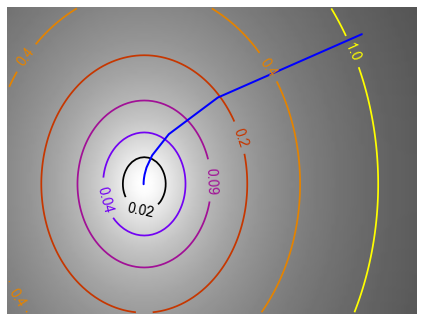

In [40]:
plot_opt(gd_output, f)

### Nelder-Mead Algorithm

While there are a variety of gradient-based mutlivariate optimization methods at our disposal, for many problems of interest, first and second derivatives may not be available. The Nelder–Mead algorithm is an alternative approach that uses direct search instead of gradient ascent. It works by refining a simplex, the generalization of intervals and triangles to high-dimensional spaces, to bracket the minimum.

Since it is not based on gradients, it is robust when the target function is not smooth, though it is slower for smooth functions.

In [41]:
def rosenbrock(x):
    y = 4*x
    y[0] += 1
    y[1:] += 3
    return np.sum(.5*(1 - y[:-1])**2 + (y[1:] - y[:-1]**2)**2)

In [42]:
from scipy import optimize

def nelder_mead(f, x0):
    output = pd.DataFrame(columns=['x','y','fxy'])
    
    def store(X):
        output.loc[len(output)] = X[0], X[1], f(X)
        
    optimize.fmin(f, x0, callback=store, ftol=1e-12)
    
    return output

In [43]:
nm_output = nelder_mead(rosenbrock, np.array([x0, y0]))

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 79
         Function evaluations: 151


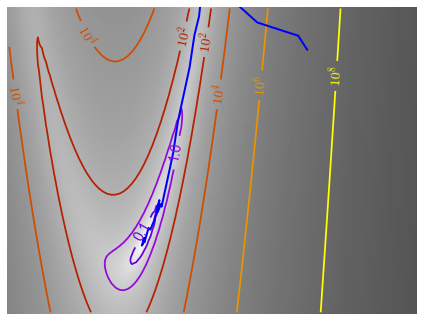

In [44]:
plot_opt(nm_output, rosenbrock)

### Example: truncated distribution

Suppose that we observe $Y$ truncated below at $a$ (where $a$ is known). If $X$ is the distribution of our observation, then:

$$ P(X \le x) = P(Y \le x|Y \gt a) = \frac{P(a \lt Y \le x)}{P(Y \gt a)}$$

(so, $Y$ is the original variable and $X$ is the truncated variable) 

Then X has the density:

$$f_X(x) = \frac{f_Y (x)}{1−F_Y (a)} \, \text{for} \, x \gt a$$ 

Suppose $Y \sim N(\mu, \sigma^2)$ and $x_1,\ldots,x_n$ are independent observations of $X$. We can use maximum likelihood to find $\mu$ and $\sigma$. 

First, we can simulate a truncated distribution using a `while` statement to eliminate samples that are outside the support of the truncated distribution.

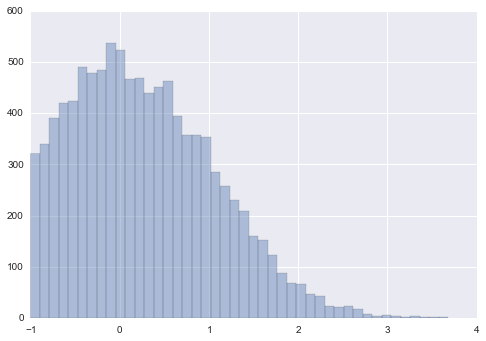

In [45]:
x = np.random.normal(size=10000)
a = -1
x_small = x < a
while x_small.sum():
    x[x_small] = np.random.normal(size=x_small.sum())
    x_small = x < a
    
sns.distplot(x, kde=False)

We can construct a log likelihood for this function using the conditional form:

$$f_X(x) = \frac{f_Y (x)}{1−F_Y (a)} \, \text{for} \, x \gt a$$ 

In [46]:
from scipy.stats.distributions import norm

trunc_norm = lambda theta, a, x: -(np.log(norm.pdf(x, theta[0], theta[1])) - 
            np.log(1 - norm.cdf(a, theta[0], theta[1]))).sum()

For this example, we will use another optimization algorithm, the **Nelder-Mead simplex algorithm**. It has a couple of advantages: 

- it does not require derivatives
- it can optimize (minimize) a vector of parameters

SciPy implements this algorithm in its `fmin` function:

In [47]:
optimize.fmin(trunc_norm, np.array([1,2]), args=(-1, x))

Optimization terminated successfully.
         Current function value: 11002.955131
         Iterations: 43
         Function evaluations: 83


array([ 0.01158844,  0.99120155])

In general, simulating data is a terrific way of testing your model before using it with real data.

## References

Chapter 2 of [Givens, Geof H.; Hoeting, Jennifer A. (2012-10-09). Computational Statistics (Wiley Series in Computational Statistics)](http://www.stat.colostate.edu/computationalstatistics/)

[Python Scientific Lecture Notes](http://scipy-lectures.github.io)